In [1]:
%matplotlib inline 
import os
import math
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# import tensorflow_datasets as tfds

# Data Loading

In [2]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_dir = tf.keras.utils.get_file(
    origin=_URL,
    fname="cats_dogs_dataset.zip"
)
print("Local directory: ", zip_dir)

68616192/68606236 [==============================] - 234s 3us/step
Local directory:  /Users/vuong/.keras/datasets/cats_dogs_dataset.zip


In [ ]:
zip_dir_target = os.path.dirname(zip_dir)
print(zip_dir)
print(zip_dir_target)
!unzip $zip_dir -d $zip_dir_target

In [4]:
!find /Users/vuong/.keras/datasets -type d -print

/Users/vuong/.keras/datasets
/Users/vuong/.keras/datasets/cats_and_dogs_filtered
/Users/vuong/.keras/datasets/cats_and_dogs_filtered/train
/Users/vuong/.keras/datasets/cats_and_dogs_filtered/train/dogs
/Users/vuong/.keras/datasets/cats_and_dogs_filtered/train/cats
/Users/vuong/.keras/datasets/cats_and_dogs_filtered/validation
/Users/vuong/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/Users/vuong/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [5]:
cats_tr = os.listdir(f'{zip_dir_target}/cats_and_dogs_filtered/train/cats')
dogs_tr = os.listdir(f'{zip_dir_target}/cats_and_dogs_filtered/train/dogs')
print('Total training cat images:', len(cats_tr))
print('Total training dog images:', len(dogs_tr))

cats_val = os.listdir(f'{zip_dir_target}/cats_and_dogs_filtered/validation/cats')
dogs_val = os.listdir(f'{zip_dir_target}/cats_and_dogs_filtered/validation/dogs')
print('Total validation cat images:', len(cats_val))
print('Total validation dog images:', len(dogs_val))
print("--")

total_tr = len(cats_tr)+len(dogs_tr)
total_val = len(cats_val)+len(dogs_val)
print("Total training images:", total_tr)
print("Total validation images:", total_val)

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Data Preparation

Generates a tf.data.Dataset from image files in a directory.



In [6]:
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    f'{zip_dir_target}/cats_and_dogs_filtered/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=total_tr,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    f'{zip_dir_target}/cats_and_dogs_filtered/validation',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=total_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2000 files belonging to 2 classes.
Metal device set to: AMD Radeon Pro 5300M
Found 1000 files belonging to 2 classes.


2021-11-02 20:04:02.314736: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-02 20:04:02.315555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-02 20:04:02.315820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
print("Class names: ", ds_train.class_names)
class_names = ds_train.class_names

Class names:  ['cats', 'dogs']


In [8]:
for images, labels in ds_train.take(1):
    print("First batch of training data: ", images.shape)
for images, labels in ds_test.take(1):
    print("First batch of testing data: ", images.shape)

2021-11-02 20:04:03.385627: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


First batch of training data:  (2000, 150, 150, 3)
First batch of testing data:  (1000, 150, 150, 3)


## Convert Image Data to Animal object

In [9]:
class Animal:
    def __init__(self, image, label):
        self.image = image
        self.label = label

    def normalize(self):
        self.image = self.image / 255
    
    def visualize(self, plt, class_names=[], original=False):
        if original:
            plt.imshow(self.image.astype('uint8'))
        else:
            plt.imshow(self.image)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if not class_names:
            plt.xlabel(self.label)
        else:
            plt.xlabel(class_names[self.label])

In [10]:
def generate_dataset():
    animals_train = []
    animals_test = []

    for images, labels in ds_train.take(1):
        for i in range(total_tr):
            image = images[i].numpy()
            label = np.argmax(labels[i].numpy())
            animals_train.append(Animal(image, label))

    for images, labels in ds_test.take(1):
        for i in range(total_val):
            image = images[i].numpy()
            label = np.argmax(labels[i].numpy())
            animals_test.append(Animal(image, label))

    print("Total training animals:", len(animals_train))
    print("Total training animals:", len(animals_test))
    
    return animals_train, animals_test

animals_train, animals_test = generate_dataset()

Total training animals: 2000
Total training animals: 1000


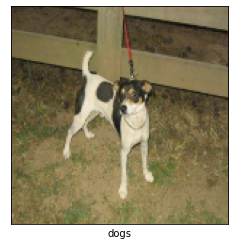

In [11]:
# Visualize the first animal in the training data
animals_train[0].visualize(plt, class_names=['cats', 'dogs'], original=True)
plt.show()

## Normalization

Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

In [12]:
# Normalizing
animals_train_nor, animals_test_nor = generate_dataset()

for i in range(len(animals_train_nor)):
    animals_train_nor[i].normalize()

for i in range(len(animals_test_nor)):
    animals_test_nor[i].normalize()

Total training animals: 2000
Total training animals: 1000


In [13]:
# Print the first animal in the training data after normalization
print(animals_train_nor[0].image)

[[[0.11758824 0.11366667 0.10290196]
  [0.19166665 0.19166665 0.15645097]
  [0.15416667 0.15416667 0.10710784]
  ...
  [0.05026149 0.06594777 0.06986934]
  [0.04313726 0.05882353 0.0627451 ]
  [0.05882353 0.05882353 0.05882353]]

 [[0.13327451 0.12935294 0.12022875]
  [0.16309802 0.16109802 0.13572547]
  [0.1479085  0.1479085  0.10281045]
  ...
  [0.05026149 0.06594777 0.06986934]
  [0.04313726 0.05882353 0.0627451 ]
  [0.05882353 0.05882353 0.05882353]]

 [[0.07008823 0.06910784 0.0612647 ]
  [0.15384312 0.15628429 0.12941174]
  [0.10151961 0.10446079 0.07112745]
  ...
  [0.05026149 0.06594777 0.06986934]
  [0.04313726 0.05882353 0.0627451 ]
  [0.05882353 0.05882353 0.05882353]]

 ...

 [[0.8663268  0.86240524 0.84671897]
  [0.8612843  0.85736275 0.8416765 ]
  [0.87352943 0.86960787 0.8539216 ]
  ...
  [0.73039216 0.73039216 0.73039216]
  [0.7279314  0.7279314  0.7279314 ]
  [0.7235294  0.71568626 0.72745097]]

 [[0.85652286 0.8526013  0.836915  ]
  [0.8431764  0.83925486 0.8235686 ]


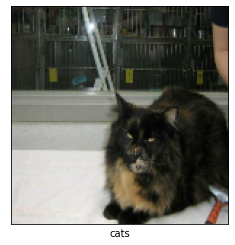

In [14]:
# Visualize the first animal in the training data
animals_train_nor[0].visualize(plt, class_names=['cats', 'dogs'])
plt.show()

## Create a Dataset in TensorFlow

We have a numpy array and we want to pass it to TensorFlow.


In [15]:
print("Total training images:", len(animals_train_nor))
print("Total validation images:", len(animals_test_nor))

Total training images: 2000
Total validation images: 1000


In [16]:
X_train, y_train = [], []
X_test, y_test = [], []

for animal in animals_train_nor:
    X_train.append(animal.image)
    y_train.append(animal.label)

for animal in animals_test_nor:
    X_test.append(animal.image)
    y_test.append(animal.label)

print("Total training images:", len(X_train))
print("Total training labels:", len(y_train))
print("Total validation images:", len(X_test))
print("Total validation labels:", len(y_test))

Total training images: 2000
Total training labels: 2000
Total validation images: 1000
Total validation labels: 1000


# Visualizing Training images

We can visualize our training images by getting a batch of images from the training dataset, and then plotting a few of them using matplotlib.

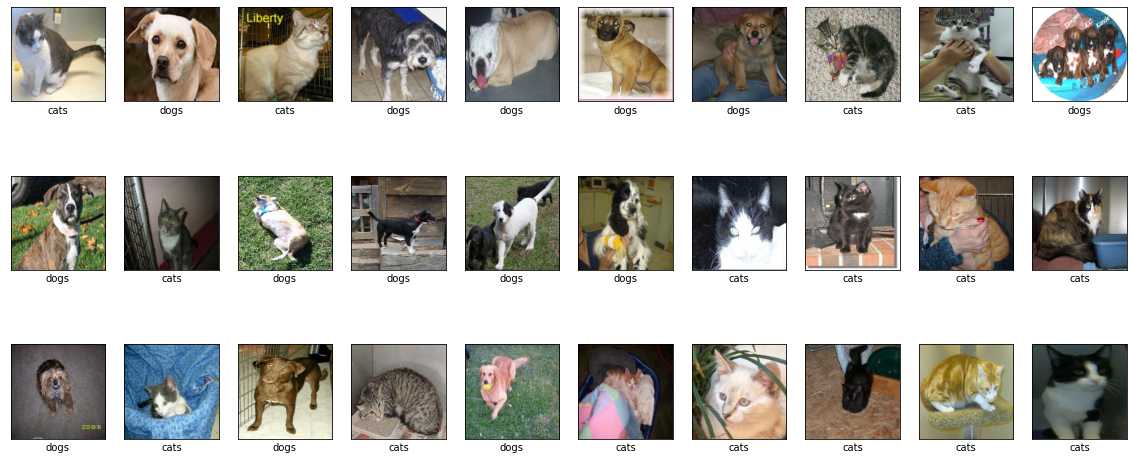

In [17]:
import random
random_list = random.sample(range(0, 2000), 30)

def show_image(image, label):
    plt.imshow(X=image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(label)

plt.figure(figsize=(20,15))
idx=0
for i in random_list:
    plt.subplot(5, 10, idx+1)
    image = X_train[i]  # For normalize only
    label = class_names[y_train[i]]
    show_image(image, label)
    idx+=1
plt.show()

# Baseline Model

In [18]:
def baseline_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu, padding="same", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu, padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
        tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
    ])
    return model

## Train the model
It's time we train our network.

In [19]:
EPOCHS = 100
BATCH_SIZE = 100

training_dataset = tf.data.Dataset.from_tensor_slices((np.array(X_train), np.array(y_train)))
testing_dataset = tf.data.Dataset.from_tensor_slices((np.array(X_test), np.array(y_test)))

training_dataset = training_dataset.batch(batch_size=BATCH_SIZE)
testing_dataset = testing_dataset.batch(batch_size=BATCH_SIZE)

print("Total training dataset:", len(list(training_dataset)))
print("Total testing dataset:", len(list(testing_dataset)))

Total training dataset: 20
Total testing dataset: 10


In [20]:
model = baseline_model()

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history = model.fit(
    training_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=testing_dataset,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               8

2021-11-02 20:04:46.336626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 3.6725 - sparse_categorical_accuracy: 0.5040

2021-11-02 20:04:56.747538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 12s 462ms/step - loss: 3.6725 - sparse_categorical_accuracy: 0.5040 - val_loss: 0.6923 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/100
20/20 [==============================] - 9s 450ms/step - loss: 0.6974 - sparse_categorical_accuracy: 0.5365 - val_loss: 0.6787 - val_sparse_categorical_accuracy: 0.6090
Epoch 3/100
20/20 [==============================] - 9s 451ms/step - loss: 0.6816 - sparse_categorical_accuracy: 0.5775 - val_loss: 0.6689 - val_sparse_categorical_accuracy: 0.6210
Epoch 4/100
20/20 [==============================] - 9s 450ms/step - loss: 0.6460 - sparse_categorical_accuracy: 0.6335 - val_loss: 0.6566 - val_sparse_categorical_accuracy: 0.6140
Epoch 5/100
20/20 [==============================] - 9s 449ms/step - loss: 0.5712 - sparse_categorical_accuracy: 0.7085 - val_loss: 0.6577 - val_sparse_categorical_accuracy: 0.6240
Epoch 6/100
20/20 [==============================] - 9s 449ms/step - loss: 0.5056 - sparse_categorical_acc

Epoch 46/100
20/20 [==============================] - 9s 452ms/step - loss: 1.1913e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5556 - val_sparse_categorical_accuracy: 0.6030
Epoch 47/100
20/20 [==============================] - 9s 451ms/step - loss: 1.1072e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5748 - val_sparse_categorical_accuracy: 0.6030
Epoch 48/100
20/20 [==============================] - 9s 451ms/step - loss: 1.0327e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.5930 - val_sparse_categorical_accuracy: 0.6020
Epoch 49/100
20/20 [==============================] - 9s 450ms/step - loss: 9.6679e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.6107 - val_sparse_categorical_accuracy: 0.6020
Epoch 50/100
20/20 [==============================] - 9s 451ms/step - loss: 9.0817e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.6276 - val_sparse_categorical_accuracy: 0.6000
Epoch 51/100
20/20 [==============================] - 9s 453ms/step - 

20/20 [==============================] - 9s 458ms/step - loss: 1.8365e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.0967 - val_sparse_categorical_accuracy: 0.6000
Epoch 91/100
20/20 [==============================] - 9s 458ms/step - loss: 1.7804e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.1081 - val_sparse_categorical_accuracy: 0.6010
Epoch 92/100
20/20 [==============================] - 9s 460ms/step - loss: 1.7267e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.1165 - val_sparse_categorical_accuracy: 0.6010
Epoch 93/100
20/20 [==============================] - 9s 456ms/step - loss: 1.6773e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.1283 - val_sparse_categorical_accuracy: 0.6010
Epoch 94/100
20/20 [==============================] - 9s 459ms/step - loss: 1.6251e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.1411 - val_sparse_categorical_accuracy: 0.5990
Epoch 95/100
20/20 [==============================] - 9s 465ms/step - loss: 1.5744e

## Visualizing results of the training
We'll now visualize the results we get after training our network.

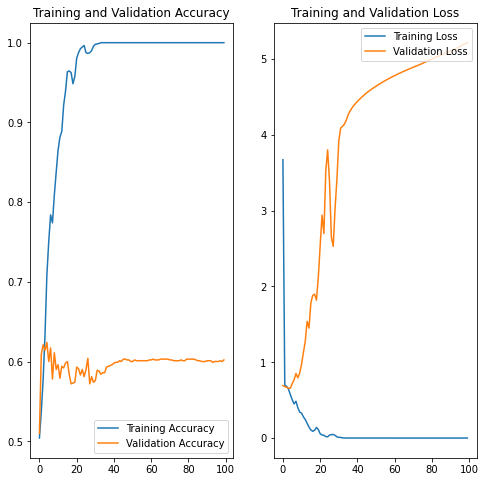

In [21]:
def visualize_model(history, epochs):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

visualize_model(history, EPOCHS)

# Fine Tuning

## Data augmentation

Data augmentation takes the approach of generating additional training images by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data, prevent overfitting and generalize better.



In the cell below, use Keras to create a transformation that applies a random horizontal/vertical flip, a random 90 degree rotation, a random zoom of up to 150%, and a range for randomly picking a brightness shift value from.

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

EPOCHS = 100
BATCH_SIZE = 100

In [23]:
# Re-generate data
animals_train, animals_test = generate_dataset()

X_train, y_train = [], []
X_test, y_test = [], []

for animal in animals_train:
    X_train.append(animal.image)
    y_train.append(animal.label)

for animal in animals_test:
    X_test.append(animal.image)
    y_test.append(animal.label)

print("Total training images:", len(X_train))
print("Total training labels:", len(y_train))
print("Total validation images:", len(X_test))
print("Total validation labels:", len(y_test))

Total training animals: 2000
Total training animals: 1000
Total training images: 2000
Total training labels: 2000
Total validation images: 1000
Total validation labels: 1000


Takes data and label arrays, then generates batches of augmented data.

In [24]:
def get_data_from_numpy():
    training_data_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    train_data_gen = training_data_generator.flow(x=np.array(X_train), 
                                                  y=np.array(y_train), 
                                                  batch_size=BATCH_SIZE, 
                                                  shuffle=True)
    
    val_data_generator = ImageDataGenerator(rescale=1./255)
    val_data_gen = val_data_generator.flow(x=np.array(X_test), 
                                           y=np.array(y_test))
    
    return train_data_gen, val_data_gen

Takes the path to a directory and generates batches of augmented data.

In [25]:
def get_data_from_directory():
    training_data_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    train_data_gen = training_data_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                         directory=f'{zip_dir_target}/cats_and_dogs_filtered/train',
                                                         shuffle=True,
                                                         target_size=(150,150),
                                                         class_mode='binary')

    val_data_generator = ImageDataGenerator(rescale=1./255)
    val_data_gen = val_data_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=f'{zip_dir_target}/cats_and_dogs_filtered/validation',
                                                     target_size=(150,150),
                                                     class_mode='binary')
    return train_data_gen, val_data_gen

Let's visualize how a single image would look like different times, when we pass these augmentations randomly to our dataset.

In [26]:
def plot_images_from_image_generators(img_generator):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
    for i in range(5):
        img, label = img_generator.next()
        ax[i].imshow(img[0])
        ax[i].axis("off")

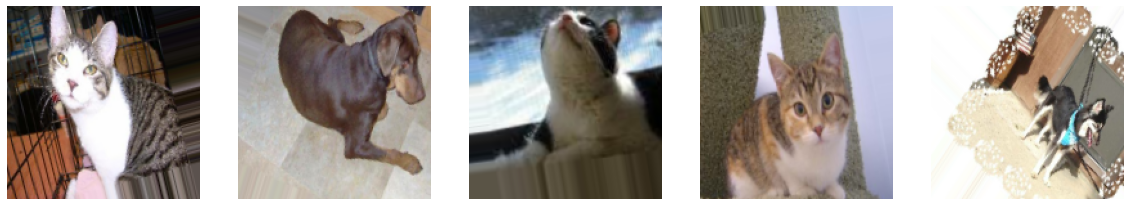

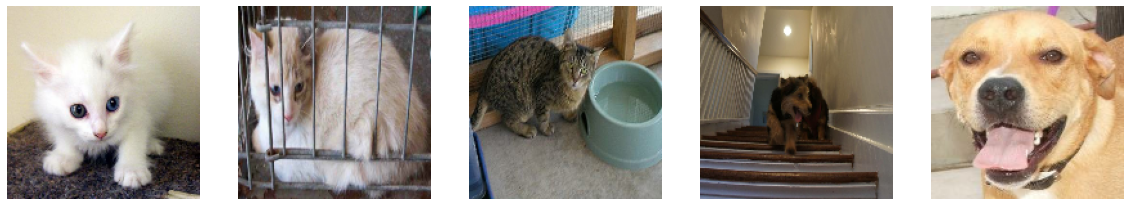

In [27]:
train_data_gen, val_data_gen = get_data_from_numpy()

plot_images_from_image_generators(train_data_gen)
plot_images_from_image_generators(val_data_gen)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


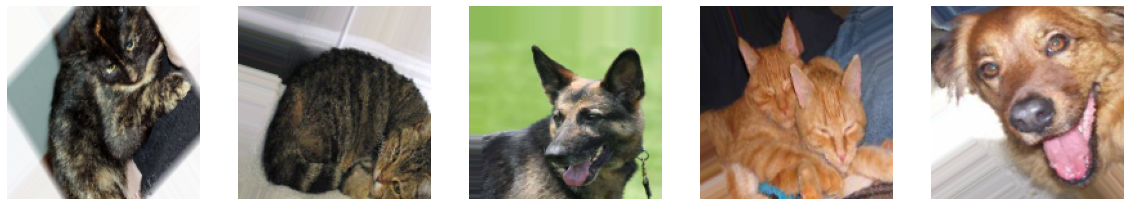

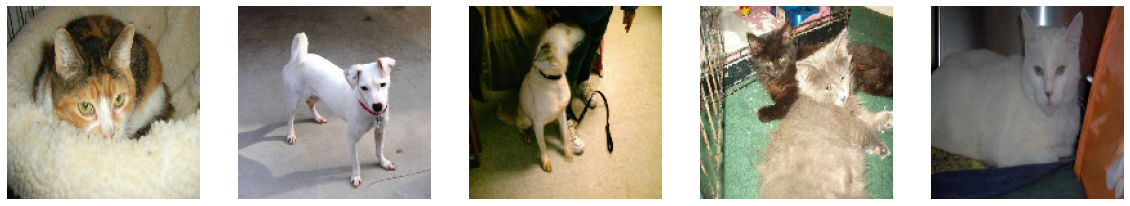

In [28]:
train_data_gen, val_data_gen = get_data_from_directory()

plot_images_from_image_generators(train_data_gen)
plot_images_from_image_generators(val_data_gen)

### Model with Data Augmentation

In [29]:
def get_model_with_data_augmentation():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu, padding="valid", input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu, padding="valid"),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding="valid"),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding="valid"),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
        tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    return model

In [30]:
model_1 = get_model_with_data_augmentation()
model_1.summary()

train_data_gen, val_data_gen = get_data_from_numpy()
history_1 = model_1.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_tr / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

2021-11-02 20:20:44.954532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.7558 - sparse_categorical_accuracy: 0.5135

2021-11-02 20:20:56.040465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 12s 552ms/step - loss: 0.7558 - sparse_categorical_accuracy: 0.5135 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.5031
Epoch 2/100
20/20 [==============================] - 12s 561ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.5080 - val_loss: 0.6924 - val_sparse_categorical_accuracy: 0.4969
Epoch 3/100
20/20 [==============================] - 11s 511ms/step - loss: 0.6927 - sparse_categorical_accuracy: 0.5180 - val_loss: 0.6904 - val_sparse_categorical_accuracy: 0.5469
Epoch 4/100
20/20 [==============================] - 10s 462ms/step - loss: 0.6866 - sparse_categorical_accuracy: 0.5430 - val_loss: 0.6473 - val_sparse_categorical_accuracy: 0.6406
Epoch 5/100
20/20 [==============================] - 9s 456ms/step - loss: 0.6789 - sparse_categorical_accuracy: 0.5765 - val_loss: 0.6758 - val_sparse_categorical_accuracy: 0.5312
Epoch 6/100
20/20 [==============================] - 9s 439ms/step - loss: 0.6751 - sparse_categorical_

Epoch 46/100
20/20 [==============================] - 11s 532ms/step - loss: 0.5206 - sparse_categorical_accuracy: 0.7415 - val_loss: 0.5407 - val_sparse_categorical_accuracy: 0.7281
Epoch 47/100
20/20 [==============================] - 11s 530ms/step - loss: 0.5217 - sparse_categorical_accuracy: 0.7310 - val_loss: 0.5068 - val_sparse_categorical_accuracy: 0.7375
Epoch 48/100
20/20 [==============================] - 11s 529ms/step - loss: 0.5188 - sparse_categorical_accuracy: 0.7530 - val_loss: 0.4727 - val_sparse_categorical_accuracy: 0.7625
Epoch 49/100
20/20 [==============================] - 11s 530ms/step - loss: 0.5425 - sparse_categorical_accuracy: 0.7305 - val_loss: 0.5437 - val_sparse_categorical_accuracy: 0.6938
Epoch 50/100
20/20 [==============================] - 11s 528ms/step - loss: 0.5208 - sparse_categorical_accuracy: 0.7545 - val_loss: 0.5017 - val_sparse_categorical_accuracy: 0.7438
Epoch 51/100
20/20 [==============================] - 11s 516ms/step - loss: 0.5398 -

Epoch 91/100
20/20 [==============================] - 12s 594ms/step - loss: 0.4321 - sparse_categorical_accuracy: 0.8070 - val_loss: 0.4454 - val_sparse_categorical_accuracy: 0.7844
Epoch 92/100
20/20 [==============================] - 12s 578ms/step - loss: 0.4115 - sparse_categorical_accuracy: 0.8100 - val_loss: 0.3927 - val_sparse_categorical_accuracy: 0.8313
Epoch 93/100
20/20 [==============================] - 12s 561ms/step - loss: 0.4232 - sparse_categorical_accuracy: 0.8090 - val_loss: 0.4233 - val_sparse_categorical_accuracy: 0.8219
Epoch 94/100
20/20 [==============================] - 12s 568ms/step - loss: 0.4464 - sparse_categorical_accuracy: 0.7875 - val_loss: 0.4496 - val_sparse_categorical_accuracy: 0.7937
Epoch 95/100
20/20 [==============================] - 12s 570ms/step - loss: 0.4207 - sparse_categorical_accuracy: 0.8015 - val_loss: 0.4070 - val_sparse_categorical_accuracy: 0.8094
Epoch 96/100
20/20 [==============================] - 12s 579ms/step - loss: 0.4453 -

### Visualizing the training model

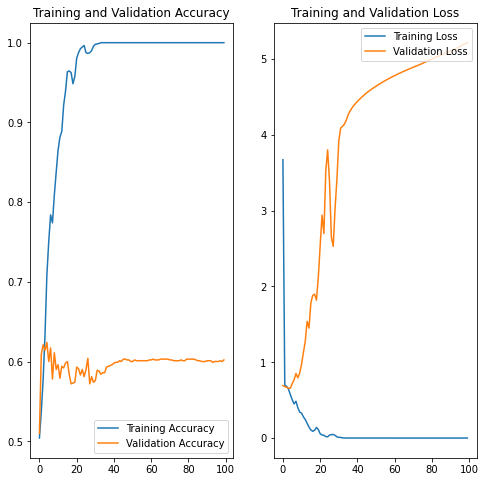

In [31]:
visualize_model(history, EPOCHS)

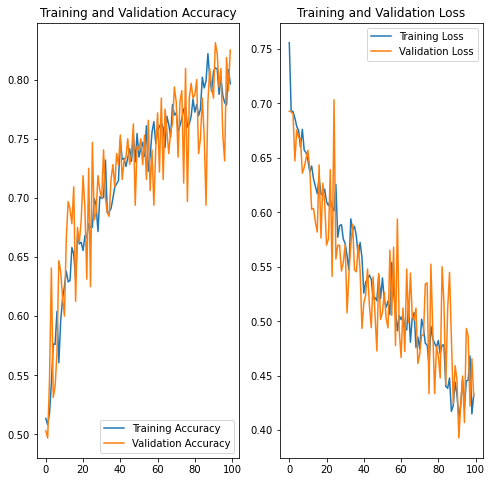

In [32]:
visualize_model(history_1, EPOCHS)

# Image Recognition: Dogs vs Cats!

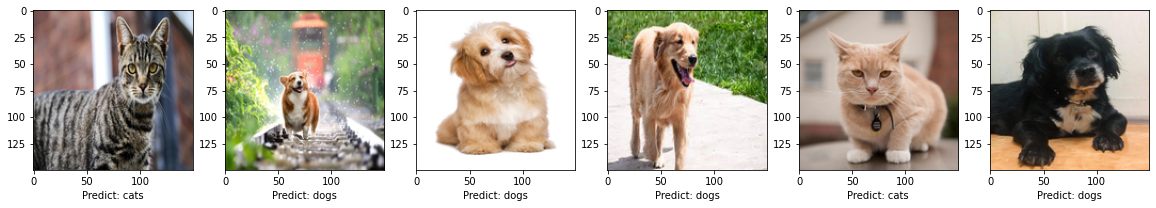

In [44]:
def image_url_to_numpy_array_skimage(url,format=None):
    from skimage import io
    from PIL import Image
    image = io.imread(url)
    image = np.asarray(image, dtype="uint8")
    if format=='BGR' :
        ## return BGR format array
        img_arr = image[...,[2,1,0]]
    else:
        img_arr = image
    return np.array(Image.fromarray(img_arr).resize((150, 150), Image.ANTIALIAS))/255


images_dir = ["data/sample_00.jpg", "data/sample_01.jpg", "data/sample_02.jpg", "data/sample_03.jpg", "data/sample_04.jpg", "data/sample_05.jpg"]
fig, ax = plt.subplots(nrows=1, ncols=len(images_dir), figsize=(20,20))
for i in range(len(images_dir)):
    sample = image_url_to_numpy_array_skimage(images_dir[i])
    ax[i].imshow(sample)
    ax[i].set_xlabel(f'Predict: {class_names[np.argmax(model_1.predict(np.array([sample])))]}')
